In [156]:
import numpy as np

from tenpy.networks.mps import MPS
from tenpy.models.model import CouplingMPOModel#, NearestNeighborModel
#from tenpy.lattice import Chain
#from ..tools.params import asConfig
from tenpy.networks.site import BosonSite#, SpinHalfFermionSite
from tenpy.algorithms import dmrg

import matplotlib.pyplot as plt
#__all__ = ['BoseHubbardModel', 'BoseHubbardChain', 'FermiHubbardModel', 'FermiHubbardChain']


In [176]:
class myModel(CouplingMPOModel):
    r"""Spinless Bose-Hubbard model.
    The Hamiltonian is:
    .. math ::
        H = - t \sum_{\langle i, j \rangle, i < j} (b_i^{\dagger} b_j + b_j^{\dagger} b_i)
            + V \sum_{\langle i, j \rangle, i < j} n_i n_j
            + \frac{U}{2} \sum_i n_i (n_i - 1) - \mu \sum_i n_i
    Here, :math:`\langle i,j \rangle, i< j` denotes nearest neighbor pairs.
    All parameters are collected in a single dictionary `model_params`, which
    is turned into a :class:`~tenpy.tools.params.Config` object.
    Parameters
    ----------
    model_params : :class:`~tenpy.tools.params.Config`
        Parameters for the model. See :cfg:config:`BoseHubbardModel` below.
    Options
    -------
    .. cfg:config :: BoseHubbardModel
        :include: CouplingMPOModel
        n_max : int
            Maximum number of bosons per site.
        filling : float
            Average filling.
        conserve: {'best' | 'N' | 'parity' | None}
            What should be conserved. See :class:`~tenpy.networks.Site.BosonSite`.
        t, U, V, mu: float | array
            Couplings as defined in the Hamiltonian above. Note the signs!
    """
    def init_sites(self, model_params):
        n_max = model_params.get('n_max', 3)
        filling = model_params.get('filling', 0.5)
        conserve = model_params.get('conserve', 'N')
        if conserve == 'best':
            conserve = 'N'
            self.logger.info("%s: set conserve to %s", self.name, conserve)
        site = BosonSite(Nmax=n_max, conserve=conserve, filling=filling)
        return site

    def init_terms(self, model_params):
        # 0) Read and set parameters.
        rc = model_params.get('rc', 4)
        t = model_params.get('t', 1.)
        U = model_params.get('U', 0.)
        V = model_params.get('V', 0.)
        mu = model_params.get('mu', 0)
#        for u in range(len(self.lat.unit_cell)):
#            self.add_onsite(-mu - U / 2., u, 'N')
#            self.add_onsite(U / 2., u, 'NN')
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            print(u1)
            self.add_coupling(-t, u1, 'Bd', u2, 'B', dx, plus_hc=True)
#            self.add_coupling(V, u1, 'N', u2, 'N', dx)
        for dx in range(1,rc+1):
            self.add_coupling(V/2, 0, 'N', 0, 'N', dx)
            self.add_coupling(V/2, 0, 'N', 0, 'N', -dx)

In [177]:
model_params = dict(L=20, n_max=1, t=0.5, V=2.5, rc=5, conserve='N', filling=1/4, bc_MPS='finite')
M = myModel(model_params)
product_state = ['vac','vac','vac',1]*(M.lat.N_sites//4)
psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)

0


<BarContainer object of 20 artists>

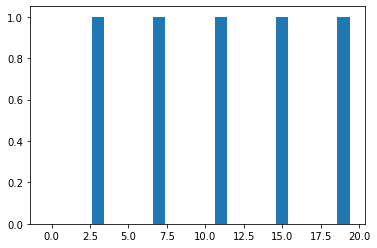

In [178]:
plt.bar(range(20), psi.expectation_value('N'))

In [179]:
dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'combine': True
    }
info = dmrg.run(psi, M, dmrg_params)

/home/lucarinna/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:233: UserWarning: unused options for config trunc_params:
['chi_max', 'svd_min']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/lucarinna/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:233: UserWarning: unused options for config DMRG:
['bc_MPS', 'max_E_err', 'mixer']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


<BarContainer object of 20 artists>

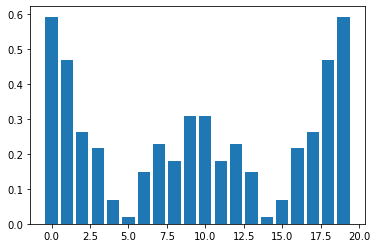

In [180]:
plt.bar(range(20), psi.expectation_value('N'))